In [ ]:
library(dplyr);library(ggplot2);library(corrplot)
match <- read.csv("match.csv", header=T)
match1 <- match%>%mutate(goalmargin = home_team_goal-away_team_goal)%>%
  mutate(outcome = ifelse(goalmargin==0, 0, goalmargin/abs(goalmargin)))
matchhome <- select(match1, seq(33,62,3))
matchdraw <- select(match1, seq(34,62,3))
matchaway <- select(match1, seq(35,62,3))
avghome <- transmute(matchhome, homeodds=round(rowMeans(matchhome[,-11,-12],na.rm=T),digits=3))
avgdraw <- transmute(matchdraw, drawodds=round(rowMeans(matchdraw[,-11,-12],na.rm=T),digits=3))
avgaway <- transmute(matchaway, awayodds=round(rowMeans(matchaway[,-11,-12],na.rm=T),digits=3))
match1 <- bind_cols(match1,avghome,avgdraw,avgaway)
match1 <- select(match1,-seq(33,62),-c(9,10))
# every match
allmatches <- select(match1,seq(6,8),seq(31,35))
allmatches <- allmatches[complete.cases(allmatches), ]
# every match that dog wins
dogwins <- allmatches%>%filter(outcome==1 & homeodds>=3.5 | outcome==-1 & awayodds>=3.5)

## visualise corr btw goalmargin and odds

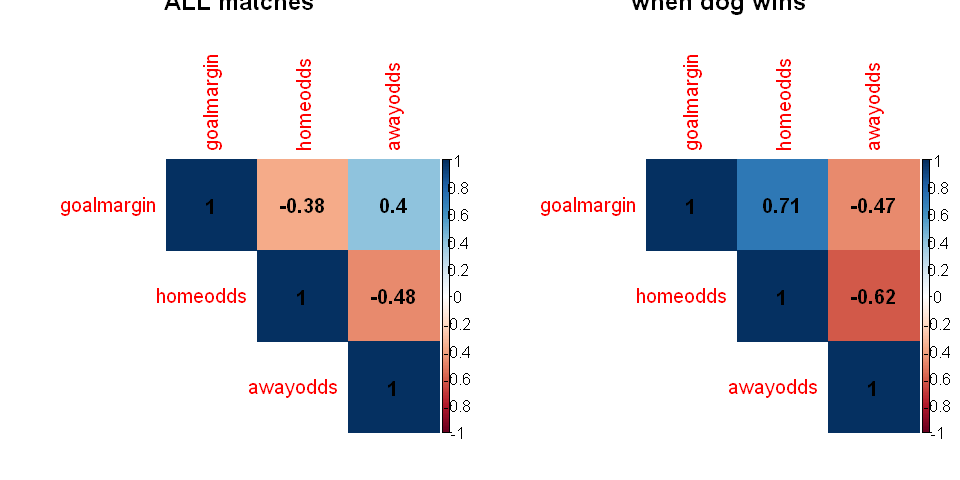

In [2]:
library(repr); options(repr.plot.width=8, repr.plot.height=4); par(mfrow=c(1,2))
corrplot(cor(allmatches[,c("goalmargin","homeodds","awayodds")]),title="ALL matches",type="upper",method="color",addCoef.col = "black",number.cex = 1)
corrplot(cor(dogwins[,c("goalmargin","homeodds","awayodds")]),title="when dog wins",type="upper",method="color",addCoef.col = "black",number.cex = 1)

## profit if bet ON dogs

In [6]:
homedogs <- allmatches%>%filter(homeodds>=3.5)%>%group_by(home_team_id)%>%summarise(homegames=n())
awaydogs <- allmatches%>%filter(awayodds>=3.5)%>%group_by(away_team_id)%>%summarise(awaygames=n())
homedata <- dogwins%>%filter(outcome==1)%>%group_by(home_team_id)%>%
  summarise(homewins=n(),homerevenue=sum(homeodds))%>%left_join(homedogs)%>%filter(!is.na(homewins))%>%
  mutate(homerev_multiple = homerevenue/homegames)%>%rename(dog=home_team_id)
awaydata <- dogwins%>%filter(outcome==-1)%>%group_by(away_team_id)%>%
  summarise(awaywins=n(),awayrevenue=sum(awayodds))%>%left_join(awaydogs)%>%filter(!is.na(awaywins))%>%
  mutate(awayrev_multiple = awayrevenue/awaygames)%>%rename(dog=away_team_id)
dogdata <- left_join(homedata,awaydata)
dogdata <- dogdata%>%filter(homegames>=10,awaygames>=10)
head(dogdata)
#write.csv(dogdata,'dogdata.csv',row.names=F)

Joining, by = "home_team_id"
Joining, by = "away_team_id"
Joining, by = "dog"


dog,homewins,homerevenue,homegames,homerev_multiple,awaywins,awayrevenue,awaygames,awayrev_multiple
1773,3,15.591,11,1.4173636,5,21.555,37,0.5825676
2033,1,5.308,24,0.2211667,7,37.513,53,0.7077925
4087,2,13.167,14,0.9405000,12,56.523,61,0.9266066
6403,5,26.929,29,0.9285862,8,39.429,53,0.7439434
6413,4,16.870,13,1.2976923,4,27.589,38,0.7260263
6433,1,6.211,10,0.6211000,6,37.106,30,1.2368667


homerev_multiple is how many times the return is over total bet amt, if bet that dog wins at home

## profit if bet AGAINST favourites

In [12]:
homefav <- allmatches%>%filter(awayodds>=3.5)%>%group_by(home_team_id)%>%summarise(homegames=n())
awayfav <- allmatches%>%filter(homeodds>=3.5)%>%group_by(away_team_id)%>%summarise(awaygames=n())
homedata1 <- allmatches%>%filter(awayodds>=3.5,outcome==-1)%>%group_by(home_team_id)%>%
  summarise(homelosses=n(),againsthomerevenue=sum(awayodds))%>%left_join(homefav)%>%filter(!is.na(homelosses))%>%
  mutate(againsthomerev_multiple = againsthomerevenue/homegames)%>%rename(fav=home_team_id)
awaydata1 <- allmatches%>%filter(homeodds>=3.5,outcome==1)%>%group_by(away_team_id)%>%
  summarise(awaylosses=n(),againstawayrevenue=sum(homeodds))%>%left_join(awayfav)%>%filter(!is.na(awaylosses))%>%
  mutate(againstawayrev_multiple = againstawayrevenue/awaygames)%>%rename(fav=away_team_id)
favdata <- left_join(homedata1,awaydata1)
favdata <- favdata%>%filter(homegames>=10,awaygames>=10)
head(favdata)
#write.csv(favdata,'favdata.csv',row.names=F)

Joining, by = "home_team_id"
Joining, by = "away_team_id"
Joining, by = "fav"


fav,homelosses,againsthomerevenue,homegames,againsthomerev_multiple,awaylosses,againstawayrevenue,awaygames,againstawayrev_multiple
8178,16,95.833,111,0.8633604,12,52.681,41,1.2849024
8277,9,51.761,79,0.6552025,4,16.521,19,0.8695263
8302,20,115.714,121,0.9563140,3,11.857,21,0.5646190
8315,17,90.156,99,0.9106667,2,7.617,10,0.7617000
8342,11,56.380,96,0.5872917,10,44.385,46,0.9648913
8455,15,119.122,139,0.8569928,26,133.591,109,1.2256055


againsthomerev_multiple is how many times the return is over total bet amt, if bet against the fav (bet that fav loses at home)

## identify feasible gooddogs and badfavs w multiple>1 (profit positive)

In [20]:
goodhomedogs <- dogdata%>%filter(homerev_multiple>1)
goodawaydogs <- dogdata%>%filter(awayrev_multiple>1)
badhomefavs <- favdata%>%filter(againsthomerev_multiple>1)
badawayfavs <- favdata%>%filter(againstawayrev_multiple>1)
head(arrange(goodhomedogs,desc(homerev_multiple)))
head(arrange(goodawaydogs,desc(awayrev_multiple)))
head(arrange(badhomefavs,desc(againsthomerev_multiple)))
head(arrange(badawayfavs,desc(againstawayrev_multiple)))

dog,homewins,homerevenue,homegames,homerev_multiple,awaywins,awayrevenue,awaygames,awayrev_multiple
8560,7,52.106,14,3.721857,14,68.127,60,1.1354500
8191,4,28.728,13,2.209846,4,18.173,37,0.4911622
8581,6,55.205,25,2.208200,20,95.955,105,0.9138571
9790,6,32.724,15,2.181600,10,52.765,59,0.8943220
10281,4,25.312,12,2.109333,9,43.879,61,0.7193279
9905,7,35.339,17,2.078765,15,86.629,58,1.4936034


dog,homewins,homerevenue,homegames,homerev_multiple,awaywins,awayrevenue,awaygames,awayrev_multiple
10267,1,5.607,15,0.373800,5,50.078,30,1.669267
9905,7,35.339,17,2.078765,15,86.629,58,1.493603
9910,3,16.290,11,1.480909,9,57.373,39,1.471103
8722,6,30.016,22,1.364364,18,99.338,68,1.460853
10003,5,22.043,19,1.160158,12,76.184,54,1.410815
9826,3,18.259,19,0.961000,9,56.180,40,1.404500


fav,homelosses,againsthomerevenue,homegames,againsthomerev_multiple,awaylosses,againstawayrevenue,awaygames,againstawayrev_multiple
9985,17,110.480,89,1.241348,7,29.673,38,0.7808684
8586,19,127.723,112,1.140384,9,38.581,49,0.7873673
9991,17,96.910,85,1.140118,5,20.315,28,0.7255357
8592,23,149.615,134,1.116530,11,45.748,48,0.9530833
8650,18,128.632,124,1.037355,21,94.583,76,1.2445132


fav,homelosses,againsthomerevenue,homegames,againsthomerev_multiple,awaylosses,againstawayrevenue,awaygames,againstawayrev_multiple
10229,16,99.386,106,0.9376038,12,62.369,36,1.732472
9906,12,68.922,127,0.5426929,12,85.171,57,1.494228
10235,14,102.189,104,0.9825865,17,81.440,55,1.480727
8697,11,58.832,63,0.9338413,5,19.891,14,1.420786
9938,15,65.619,78,0.8412692,4,15.154,11,1.377636
9827,17,93.395,115,0.8121304,8,31.884,24,1.328500


## analyse conditions of dog winning
league,stage,season,date

### leaguescore

In [22]:
byleagueplayed <- match1%>%group_by(league_id)%>%summarise(games=n())
byleaguewin <- match1%>%filter(outcome!=0, ifelse(outcome==1,homeodds>3.5,awayodds>3.5))%>%
  group_by(league_id)%>%summarise(dogwins=n())%>%left_join(byleagueplayed)%>%
  mutate(leaguescore = dogwins/games)
head(byleaguewin)
#write.csv(byleaguewin,'byleaguewin.csv',row.names=F)

Joining, by = "league_id"


league_id,dogwins,games,leaguescore
1,173,1728,0.10011574
1729,348,3040,0.11447368
4769,322,3040,0.10592105
7809,275,2448,0.11233660
10257,308,3017,0.10208817
13274,241,2448,0.09844771


### stagescore

In [23]:
bystage <- match1%>%group_by(stage)%>%summarise(games=n())
bystagewin <- match1%>%filter(outcome!=0, ifelse(outcome==1,homeodds>3.5,awayodds>3.5))%>%
  group_by(stage)%>%summarise(dogwins=n())%>%left_join(bystage)%>%
  mutate(stagescore = dogwins/games)
head(bystagewin)
#write.csv(bystagewin,'bystagewin.csv',row.names=F)

Joining, by = "stage"


stage,dogwins,games,stagescore
1,70,740,0.09459459
2,70,740,0.09459459
3,54,740,0.07297297
4,64,740,0.08648649
5,64,740,0.08648649
6,62,740,0.08378378


### seasonscore

In [25]:
byseason <- match1%>%group_by(season)%>%summarise(games=n())
byseasonwin <- match1%>%filter(outcome!=0, ifelse(outcome==1,homeodds>3.5,awayodds>3.5))%>%
  group_by(season)%>%summarise(dogwins=n())%>%left_join(byseason)%>%
  mutate(seasonscore = dogwins/games)
head(byseasonwin)
#write.csv(byseasonwin,'byseasonwin.csv',row.names=F)

Joining, by = "season"


season,dogwins,games,seasonscore
2008/2009,262,3326,0.07877330
2009/2010,260,3230,0.08049536
2010/2011,290,3260,0.08895706
2011/2012,287,3220,0.08913043
2012/2013,312,3260,0.09570552
2013/2014,277,3032,0.09135884


### weekscore

In [29]:
match2 <- read.csv("match_with_date_cols.csv", header=T)
byweek <- match2%>%group_by(week_num)%>%summarise(games=n())
byweekwin <- match2%>%filter(outcome!=0, ifelse(outcome==1,oddsh>3.5,oddsa>3.5))%>%
  group_by(week_num)%>%summarise(dogwins=n())%>%left_join(byweek)%>%filter(games>(mean(games)-sd(games)))%>%
  mutate(weekscore = dogwins/games)
head(byweekwin)
#write.csv(byweekwin,'byweekwin.csv',row.names=F)

Joining, by = "week_num"


week_num,dogwins,games,weekscore
2,50,498,0.10040161
3,52,577,0.09012132
4,52,550,0.09454545
5,74,755,0.09801325
6,74,689,0.10740203
7,55,672,0.08184524


### visualise conditions with mean ref line

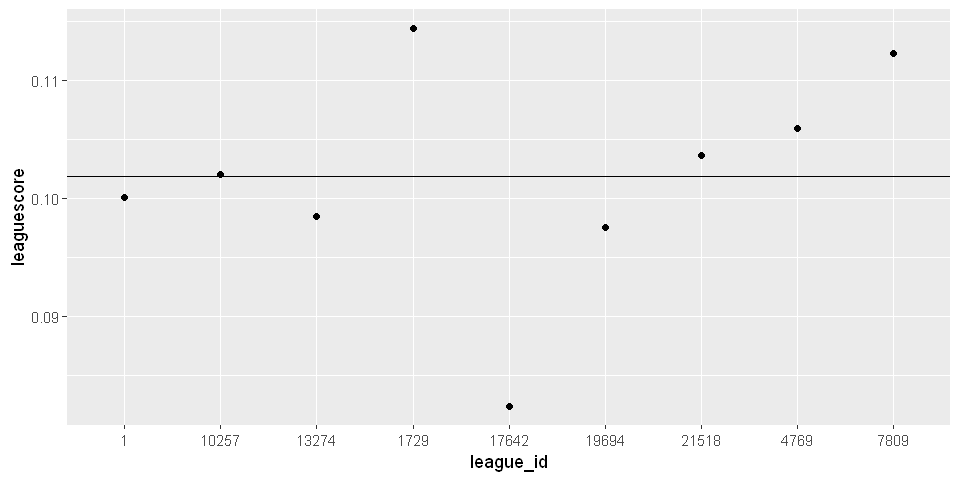

In [32]:
byleaguewin[1] <- sapply(byleaguewin[1], as.character)
ggplot(byleaguewin, aes(league_id, leaguescore)) +geom_point()+geom_hline(aes(yintercept =(mean(leaguescore))))

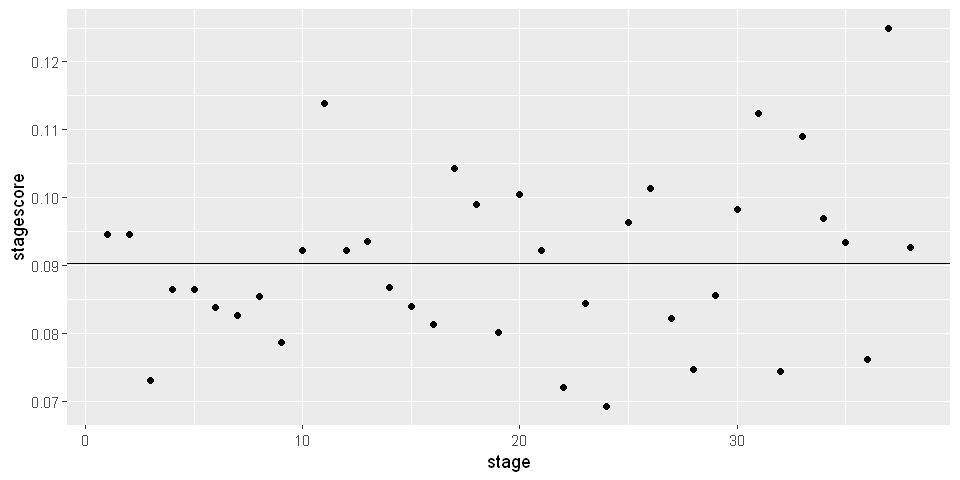

In [33]:
ggplot(bystagewin, aes(stage, stagescore)) +geom_point()+geom_hline(aes(yintercept =(mean(stagescore))))

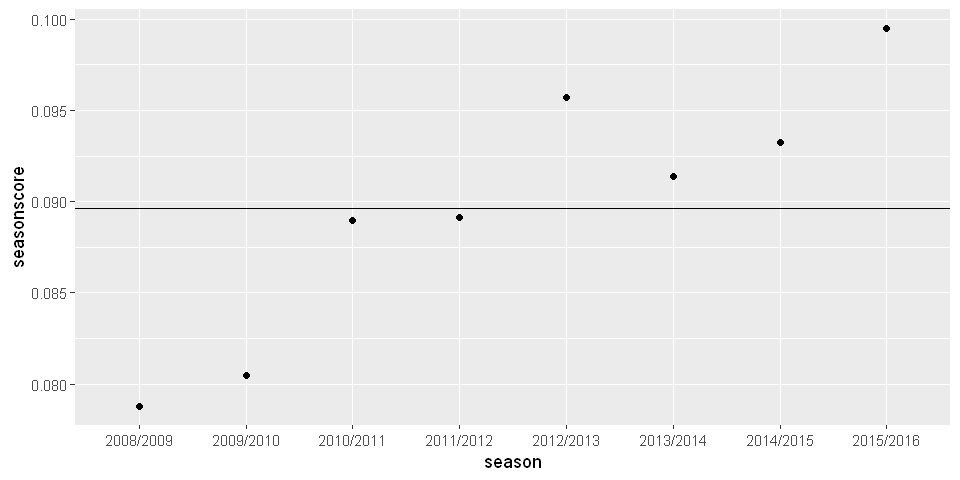

In [34]:
ggplot(byseasonwin, aes(season, seasonscore)) +geom_point()+geom_hline(aes(yintercept =(mean(seasonscore))))

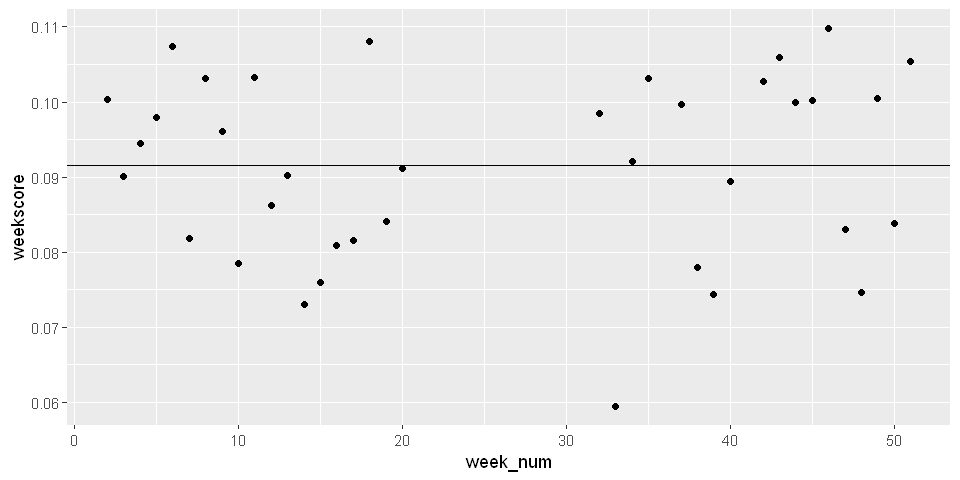

In [37]:
ggplot(byweekwin, aes(week_num, weekscore)) +geom_point()+geom_hline(aes(yintercept =(mean(weekscore))))